In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

from typing import Callable, List, Tuple

In [2]:
np.random.seed(0)

In [3]:
OBJETIVE_FUNCTION_BOUNDS = [-5.0, 5.0, -5.0, 5.0]


def objective_function(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Objective function to be optimized, representing a four-peak function.

    Parameters:
    x (np.ndarray): x-coordinates of the points.
    y (np.ndarray): y-coordinates of the points.

    Returns:
    np.ndarray: Values of the objective function at the given points.
    """
    
    return (
        np.exp(-((x - 4) ** 2) - (y - 4) ** 2)
        + np.exp(-((x + 4) ** 2) - (y - 4) ** 2)
        + 2 * np.exp(-(x**2) - y**2)
        + 2 * np.exp(-(x**2) - (y + 4) ** 2)
    )

In [4]:
def initialize_fireflies(
    number_of_fireflies: int, bounds: List[float]
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Initialize fireflies randomly within the given bounds.

    Parameters:
    number_of_fireflies (int): Number of fireflies to initialize.
    bounds (List[float]): Bounds of the coordinates (xmin, xmax, ymin, ymax).

    Returns:
    Tuple[np.ndarray, np.ndarray, np.ndarray]: Initial x, y coordinates and light intensities.
    """
    
    x = np.random.uniform(bounds[0], bounds[1], number_of_fireflies)
    y = np.random.uniform(bounds[2], bounds[3], number_of_fireflies)

    light_intensity = np.zeros(number_of_fireflies)

    return x, y, light_intensity

In [5]:
def move_fireflies(
    x, y, light_intensity, x_old, y_old, light_old, alpha, gamma, bounds
):
    """
    Move fireflies towards brighter ones and update their positions.

    Parameters:
    x (np.ndarray): Current x-coordinates of the fireflies.
    y (np.ndarray): Current y-coordinates of the fireflies.
    light_intensity (np.ndarray): Current light intensities of the fireflies.
    x_old (np.ndarray): Previous x-coordinates of the fireflies.
    y_old (np.ndarray): Previous y-coordinates of the fireflies.
    light_old (np.ndarray): Previous light intensities of the fireflies.
    alpha (float): Randomness parameter.
    gamma (float): Absorption coefficient.
    bounds (List[float]): Bounds of the coordinates (xmin, xmax, ymin, ymax).

    Returns:
    Tuple[np.ndarray, np.ndarray]: Updated x and y coordinates.
    """
    
    for i in range(len(y)):
        for j in range(len(y_old)):
            if light_intensity[i] < light_old[j]:
                distance = np.sqrt((x[i] - x_old[j]) ** 2 + (y[i] - y_old[j]) ** 2)
                beta = np.exp(-gamma * distance**2)

                x[i] = (
                    (1 - beta) * x[i]
                    + beta * x_old[j]
                    + alpha * (np.random.rand() - 0.5)
                )
                y[i] = (
                    (1 - beta) * y[i]
                    + beta * y_old[j]
                    + alpha * (np.random.rand() - 0.5)
                )

    x = np.clip(x, bounds[0], bounds[1])
    y = np.clip(y, bounds[2], bounds[3])

    return x, y

In [6]:
def firefly_algorithm(
    objective_function: Callable[[np.ndarray, np.ndarray], np.ndarray],
    objective_function_bounds: List[float],
    number_of_fireflies: int = 10,
    max_generations: int = 50,
    alpha: float = 0.2,
    gamma: float = 1.0,
):
    """
    Firefly algorithm for optimization.

    Parameters:
    objective_function (Callable[[np.ndarray, np.ndarray], np.ndarray]): Objective function to be optimized.
    objective_function_bounds (List[float]): Bounds of the coordinates (xmin, xmax, ymin, ymax).
    number_of_fireflies (int): Number of fireflies to use. Default is 10.
    max_generations (int): Number of generations to run the algorithm. Default is 50.
    alpha (float): Randomness parameter. Default is 0.2.
    gamma (float): Absorption coefficient. Default is 1.0.

    Returns:
    Tuple[np.ndarray, np.ndarray, np.ndarray]: Final x, y coordinates and light intensities.
    """
    
    x, y, light_intensity = initialize_fireflies(
        number_of_fireflies, objective_function_bounds
    )

    fireflies_positions = []

    for _ in range(max_generations):
        light_intensity = objective_function(x, y)
        light_intensity_sorted_indices = np.argsort(light_intensity)
        x, y, light_intensity = (
            x[light_intensity_sorted_indices],
            y[light_intensity_sorted_indices],
            light_intensity[light_intensity_sorted_indices],
        )

        x_old, y_old, light_intensity_old = (
            np.copy(x),
            np.copy(y),
            np.copy(light_intensity),
        )
        
        fireflies_positions.append(np.column_stack((x, y)))


        x, y = move_fireflies(
            x,
            y,
            light_intensity,
            x_old,
            y_old,
            light_intensity_old,
            alpha,
            gamma,
            objective_function_bounds,
        )

    return x, y, light_intensity, fireflies_positions

In [7]:
x, y, light_intensity, fireflies_positions = firefly_algorithm(
    objective_function,
    OBJETIVE_FUNCTION_BOUNDS,
    number_of_fireflies=25,
    max_generations=20,
)

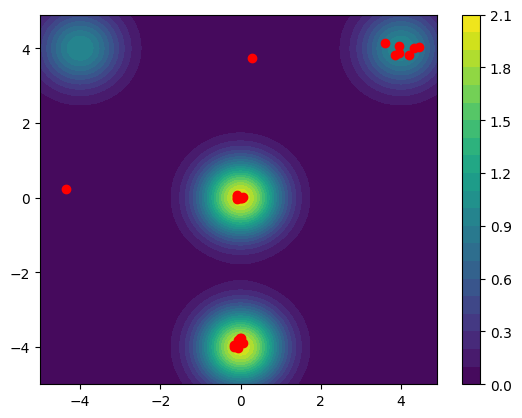

In [8]:
GRID_SIZE = 100

dx = (OBJETIVE_FUNCTION_BOUNDS[1] - OBJETIVE_FUNCTION_BOUNDS[0]) / GRID_SIZE
dy = (OBJETIVE_FUNCTION_BOUNDS[3] - OBJETIVE_FUNCTION_BOUNDS[2]) / GRID_SIZE

x, y = np.meshgrid(
    np.arange(OBJETIVE_FUNCTION_BOUNDS[0], OBJETIVE_FUNCTION_BOUNDS[1], dx),
    np.arange(OBJETIVE_FUNCTION_BOUNDS[2], OBJETIVE_FUNCTION_BOUNDS[3], dy),
)

z = objective_function(x, y)

fig, ax = plt.subplots()
contour = ax.contourf(x, y, z, 20, cmap="viridis")
plt.colorbar(contour)

scat = ax.scatter([], [], c='yellow', edgecolor='black', s=80)

def init():
    scat.set_offsets(np.empty((0, 2)))
    return scat,

def update(frame):
    data = fireflies_positions[frame]
    scat.set_offsets(data)
    return scat,

anim = FuncAnimation(fig, update, frames=len(fireflies_positions), init_func=init, blit=True)
HTML(anim.to_jshtml())
anim.save("firefly_algorithm_animation.gif", writer=PillowWriter(fps=10))